In [125]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
import torch
import torch.nn as nn
import torchvision
from torchvision.ops import box_iou
import dataset
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from model import ResNet18YOLOv1
from tqdm import tqdm
from evaluate import get_bboxes, mean_average_precision
from new_loss import Loss

In [134]:
pascal_voc_train = torchvision.datasets.VOCDetection(
    root="data",
    year="2007",
    image_set="train",
    download=False
)

In [135]:
voc_train = dataset.PascalVOC(pascal_voc=pascal_voc_train)

TRANSFORMING PASCAL VOC


In [136]:
data = voc_train[0]
resize = torchvision.transforms.Resize((448, 448))

data = (resize(data[0]).unsqueeze(0), data[1].unsqueeze(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.0000, 0.5490, 0.8574, 0.3900, 0.5195, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


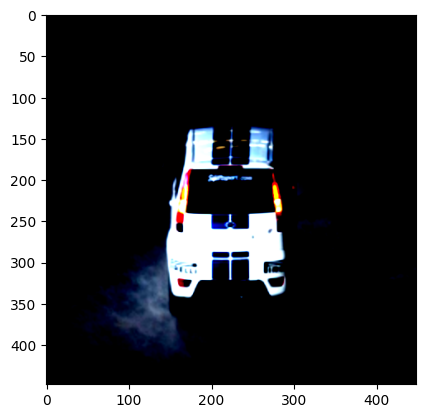

In [137]:
img = data[0].squeeze(0).permute((1, 2, 0))
Y = data[1][0][3][3]
print(Y)

plt.imshow(img)

In [184]:
device = "cpu"
# if torch.backends.mps.is_available() and torch.backends.mps.is_built():
#     device = torch.device("mps")
    
print(device)

yolo = ResNet18YOLOv1().to(device)
yolo_loss = Loss()

cpu


In [185]:
X = data[0].to(device)
Y = data[1].to(device)
pred = yolo(X)
yolo_loss(pred, Y)

tensor(15.1320, grad_fn=<DivBackward0>)

In [186]:
torch.mps.empty_cache()

In [195]:
print("TRAINING")
losses = []
EPOCHS = 200
optimizer = torch.optim.SGD(yolo.parameters(), lr=3e-6, weight_decay=0.0000, momentum=0.9)
# optimizer = torch.optim.Adam(yolo.parameters(), lr=1e-5, weight_decay=0.0005)

yolo.train()

for epoch in range(EPOCHS):
    X, Y = data
    
    X = X.to(device)
    Y = Y.to(device)
    
    pred = yolo(X)
    loss = yolo_loss(pred, Y)
    
    
    # backprop
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss.item())
    
    # calculate mAP
    # print(pred.shape, Y.shape)
    pred_bboxes = get_bboxes(pred[0])    
    target_bboxes = get_bboxes(Y[0], B=1)
    mAP = mean_average_precision([pred_bboxes], [target_bboxes])
    
    print(f"EPOCH {epoch + 1}: Loss={loss}, mAP={mAP}")

TRAINING
EPOCH 1: Loss=0.41227108240127563, mAP=0.05
EPOCH 2: Loss=0.6099141836166382, mAP=0.05
EPOCH 3: Loss=0.6789329051971436, mAP=0.05
EPOCH 4: Loss=0.4240591526031494, mAP=0.05
EPOCH 5: Loss=0.7460646629333496, mAP=0.0
EPOCH 6: Loss=0.570907711982727, mAP=0.05
EPOCH 7: Loss=0.45960676670074463, mAP=0.05
EPOCH 8: Loss=0.515146017074585, mAP=0.05
EPOCH 9: Loss=0.4155851900577545, mAP=0.05
EPOCH 10: Loss=0.4718366265296936, mAP=0.05
EPOCH 11: Loss=0.5132249593734741, mAP=0.05
EPOCH 12: Loss=0.4902697801589966, mAP=0.05
EPOCH 13: Loss=0.5236050486564636, mAP=0.05
EPOCH 14: Loss=0.4390755593776703, mAP=0.05
EPOCH 15: Loss=0.6562351584434509, mAP=0.05
EPOCH 16: Loss=0.4750022292137146, mAP=0.05
EPOCH 17: Loss=0.3424513339996338, mAP=0.05
EPOCH 18: Loss=0.4515840709209442, mAP=0.05
EPOCH 19: Loss=0.35294198989868164, mAP=0.05
EPOCH 20: Loss=0.4933752417564392, mAP=0.05
EPOCH 21: Loss=0.3374243974685669, mAP=0.05
EPOCH 22: Loss=0.5984543561935425, mAP=0.05
EPOCH 23: Loss=0.408121109008789

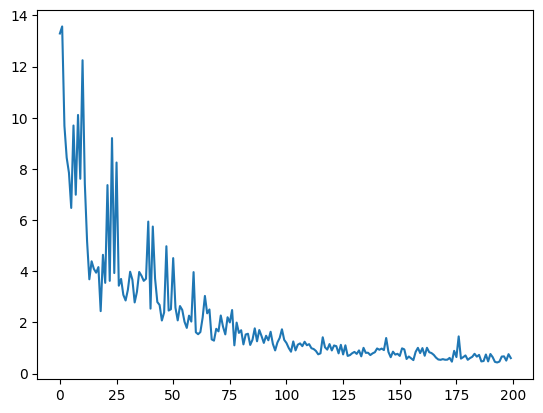

In [188]:
plt.plot(range(EPOCHS), losses)

In [189]:
yolo.eval()

yolo(X)[0][3][3]

tensor([ 0.5916,  0.5737,  0.9090,  0.3125,  0.5310,  0.3445,  0.2817,  0.4446,
        -0.1103, -0.2078, -0.0265,  0.0026, -0.0061,  0.0383,  0.0119, -0.0303,
         0.9415,  0.0207,  0.0179,  0.0166, -0.0356,  0.0236,  0.0021, -0.0190,
         0.0171,  0.0047, -0.0109,  0.0080,  0.0075,  0.0239],
       grad_fn=<SelectBackward0>)

In [190]:
yolo(X)[0][3][3][0::5]

tensor([ 0.5916,  0.3445, -0.0265, -0.0303, -0.0356,  0.0047],
       grad_fn=<SliceBackward0>)

In [191]:
Y = data[1]
Y[0][3][3]

tensor([1.0000, 0.5490, 0.8574, 0.3900, 0.5195, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [192]:
target = pascal_voc_train[0][1]
target

{'annotation': {'folder': 'VOC2007',
  'filename': '000012.jpg',
  'source': {'database': 'The VOC2007 Database',
   'annotation': 'PASCAL VOC2007',
   'image': 'flickr',
   'flickrid': '207539885'},
  'owner': {'flickrid': 'KevBow', 'name': '?'},
  'size': {'width': '500', 'height': '333', 'depth': '3'},
  'segmented': '0',
  'object': [{'name': 'car',
    'pose': 'Rear',
    'truncated': '0',
    'difficult': '0',
    'bndbox': {'xmin': '156', 'ymin': '97', 'xmax': '351', 'ymax': '270'}}]}}

In [193]:
pred = pred.view(-1, 30)
pred = pred.detach()
bboxes = []
grid_size = 448 / 7

for i in range(pred.size(0)):
    box_pred = pred[i]
    classification = box_pred[-20:]
    pred_boxes = box_pred[:-20].view(-1, 5)
    
    row = i // 7
    col = i % 7
    
    grid_x = col * grid_size
    grid_y = row * grid_size
    
    for box in pred_boxes:
        confidence = box[0].abs()
        if confidence >= 0.4:
            # change box shape to
            x = box[1]
            y = box[2]
            w = box[3]
            h = box[4]
            
            x_center = grid_x + x * grid_size
            y_center = grid_y + y * grid_size
            width = w * 448
            height = h * 448
            
            xmin = x_center - width / 2
            xmax = x_center + width / 2
            ymin = y_center - height / 2
            ymax = y_center + height / 2
            
            # print(box)
            # if row == 3 and col == 3:
            bbox = torch.tensor([confidence, xmin, ymin, xmax, ymax]) # add classification to this as well
            bboxes.append(bbox)
            print(classification)
            
bboxes = torch.stack(bboxes)
bboxes

tensor([-0.0582,  0.0801, -0.0428,  0.1045, -0.0321, -0.1271,  1.1221, -0.0120,
        -0.0470,  0.0113,  0.0322, -0.0199,  0.0361, -0.0906, -0.0616,  0.1270,
        -0.1569, -0.0270,  0.0945, -0.0953])
tensor([-0.0582,  0.0801, -0.0428,  0.1045, -0.0321, -0.1271,  1.1221, -0.0120,
        -0.0470,  0.0113,  0.0322, -0.0199,  0.0361, -0.0906, -0.0616,  0.1270,
        -0.1569, -0.0270,  0.0945, -0.0953])


tensor([[  0.6276, 166.5994, 136.5777, 293.0851, 376.3747],
        [  0.4530, 218.5143, 229.2839, 205.4056, 210.0603]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


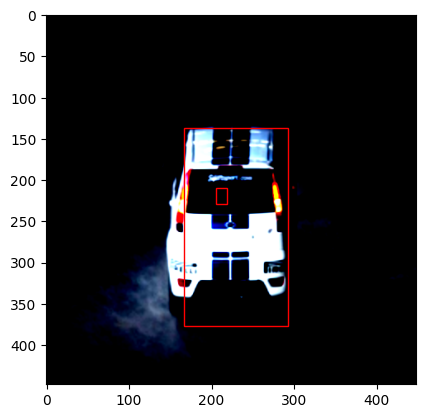

In [194]:
img = data[0].squeeze(0).permute((1, 2, 0))

fig, ax = plt.subplots()

for bbox in bboxes:
    bbox = bbox.numpy()
    xmin = bbox[1]
    ymin = bbox[2]
    width = bbox[3] - xmin
    height = bbox[4] - ymin
    
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)


ax.imshow(img)